In [110]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
##For Tuning
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from keras.utils import np_utils
import pandas as pd
from pandas import DataFrame
import seaborn as sb
#Confusion Matrix
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from itertools import cycle
from sklearn.metrics import f1_score
from PIL import Image
import h5py
import cv2


In [111]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # default plot sizes
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
hf = h5py.File('dataset/mask_dataset.hdf5', 'r')

In [113]:
list(hf.keys())

['test_img', 'test_labels', 'train_img', 'train_labels']

In [114]:
with h5py.File('dataset/mask_dataset.hdf5', 'r') as hf:
    x_test = hf['test_img'][()]
    y_test = hf['test_labels'][()]
    x_train = hf['train_img'][()]
    y_train = hf['train_labels'][()]

In [115]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]
#Each image is of size 128, 128, 3
num_px = 128

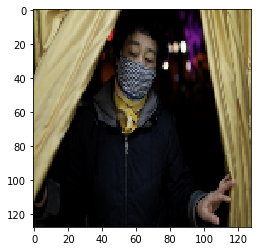

In [116]:
index = 10
plt.imshow(x_train[83])

In [117]:
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(x_train.shape))
print ("train_y shape: " + str(y_train.shape))
print ("test_x_orig shape: " + str(x_test.shape))
print ("test_y shape: " + str(y_test.shape))

Number of training examples: 2064
Number of testing examples: 517
Each image is of size: (128, 128, 3)
train_x_orig shape: (2064, 128, 128, 3)
train_y shape: (2064,)
test_x_orig shape: (517, 128, 128, 3)
test_y shape: (517,)


In [118]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [119]:
print(y_train.shape)
print(y_train)

(2064, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [120]:
y_train = keras.utils.to_categorical(y_train) 
y_test = keras.utils.to_categorical(y_test)

In [121]:
print(y_test.shape)
print(y_test)

(517, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [122]:
x_train, y_train = shuffle(x_train, y_train, random_state=43) #randomly shuffle the dataset according to a specific seed
x_test, y_test = shuffle(x_test, y_test, random_state=45)

In [123]:

def normalise(x):
    minimum = np.min(x)
    maximum = np.max(x)
    x = (x-minimum) / (maximum-minimum)
    return x


In [124]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') #convert from integer to float to ensure minor details are still there
x_train = normalise(x_train)
x_test = normalise(x_test)

In [158]:
def build_model(hp):
    #hp is equal to hyper parameters from the keras tuner module
    model = tf.keras.Sequential()
    #select a random value for the number of units in the first layer between 32 and 128 but only those which are a multiple of 32
    model.add(tf.keras.layers.Conv2D(hp.Int('input_units', min_value=32, max_value=128, step=32), (3,3),padding='same',input_shape=(128,128,3))) 
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.BatchNormalization()) #Use batch normalization in order to reduce overfitting
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) #reduce dimensionality
    model.add(tf.keras.layers.Conv2D(hp.Int('input_units', min_value=32, max_value=128, step=32), (3,3),padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #Produce a layer of drop out in the previously connected layers which has a random change of being implemented between 0 and 0.5
    model.add(tf.keras.layers.Dropout(rate=hp.Float( 'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05)))
                
    #create 4 new layers within the network of format: conv2D, Activation and Batch normalisation
    for i in range(hp.Int('n_layers', 1, 4)):
        #select a random value for the number of units in the first layer between 32 and 256 but only those which are a multiple of 32
        model.add(tf.keras.layers.Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), (3,3),padding='same'))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #Produce a layer of drop out in the previously connected layers which has a random change of being implemented between 0 and 0.5
    model.add(tf.keras.layers.Dropout(rate=hp.Float( 'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
    
    #flatten the outputs into a 1 dimensional plane
    model.add(tf.keras.layers.Flatten())
    
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(512))
    #output the networks classification using a softmax funcction
    model.add(tf.keras.layers.Dense(3))
    model.add(tf.keras.layers.Activation('softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4]) #randomly decide on a learning rate between 0.001, 0.0001, 0.00001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
    
    return model

In [159]:
#instantiate the tuner model with the objective of increasing val accuracy over 100 trials, each with a different model using random search optimisation and store in the project folder 'cifar10'
tuner_search=RandomSearch(build_model, objective='val_accuracy', max_trials=1, directory='random_search', executions_per_trial= 1,
    project_name='mask')

In [160]:
tuner_search.search(x_train, y_train, epochs=30, validation_split=0.2, batch_size=64, verbose=2)

Train on 1651 samples, validate on 413 samples
Epoch 1/30
1651/1651 - 7s - loss: 8.0654 - accuracy: 0.7795 - val_loss: 938.7903 - val_accuracy: 0.8717
Epoch 2/30
1651/1651 - 2s - loss: 0.9306 - accuracy: 0.8589 - val_loss: 118.7401 - val_accuracy: 0.8717
Epoch 3/30
1651/1651 - 2s - loss: 0.3751 - accuracy: 0.8746 - val_loss: 20.2431 - val_accuracy: 0.8717
Epoch 4/30
1651/1651 - 2s - loss: 0.3267 - accuracy: 0.8789 - val_loss: 4.4240 - val_accuracy: 0.8717
Epoch 5/30
1651/1651 - 2s - loss: 0.3443 - accuracy: 0.8752 - val_loss: 1.3797 - val_accuracy: 0.8717
Epoch 6/30
1651/1651 - 2s - loss: 0.2983 - accuracy: 0.8801 - val_loss: 0.4706 - val_accuracy: 0.8692
Epoch 7/30
1651/1651 - 2s - loss: 0.2778 - accuracy: 0.8831 - val_loss: 0.4503 - val_accuracy: 0.8717
Epoch 8/30
1651/1651 - 2s - loss: 0.2467 - accuracy: 0.8910 - val_loss: 0.4134 - val_accuracy: 0.8668
Epoch 9/30
1651/1651 - 2s - loss: 0.2378 - accuracy: 0.8922 - val_loss: 0.3413 - val_accuracy: 0.8475
Epoch 10/30
1651/1651 - 2s - l

INFO:tensorflow:Oracle triggered exit


In [161]:
tuner_search.results_summary()
tuned_model=tuner_search.get_best_models(num_models=1)[0]

In [162]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

In [163]:
loss, accuracy = tuned_model.evaluate(x_test,y_test, verbose = 0)
print('loss:', loss)
print('accuracy:', accuracy)


loss: 0.9466401548404066
accuracy: 0.8916828


In [164]:
jac = Image.open('jac.jpg')

In [165]:
jac = np.asarray(jac)
jac = np.expand_dims(jac,0)

In [166]:
model.predict(jac)

array([[1., 0., 0.]], dtype=float32)

In [167]:
tuned_model.save('best_model')


INFO:tensorflow:Assets written to: best_model\assets


In [168]:
model = tf.keras.models.load_model('best_model')

In [169]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [170]:
source=cv2.VideoCapture(0)

In [171]:
labels_dict={0:'Mask',1:'No Mask'}
color_dict={0:(0,255,0), 1:(0,0,255)}

In [ ]:
while(True):
    ret, img = source.read()
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  
    
    
    
    for x,y,w,h in faces:
        face_img = gray[y:y+w, x:x+w]
        resized = cv2.resize(face_img,(128,128))
        normalized=normalise(resized)
        reshaped=np.reshape(normalized, (1,128,128,3))
        result = model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()